Develop an analysis with sections.

In [1]:
#essential imports
import os
import numpy as np
import pandas as pd
from dmt.model.interface import Interface
from dmt.tk.phenomenon import Phenomenon
from dmt.tk.plotting import Bars
from dmt.tk.plotting.multi import MultiPlot
from neuro_dmt.library.users.visood.sscx_dissemination.analyses.composition\
    import CompositionAnalysesSuite
from neuro_dmt.models.bluebrain.circuit.atlas import\
    BlueBrainCircuitAtlas
from neuro_dmt.models.bluebrain.circuit.model import\
    BlueBrainCircuitModel
from neuro_dmt.analysis.reporting import\
    CircuitProvenance,\
    CircuitAnalysisReport
from neuro_dmt.models.bluebrain.circuit.adapter import\
    BlueBrainCircuitAdapter
from neuro_dmt.analysis.reporting import CheetahReporter

In [2]:
#paths
project =\
    os.path.join(
        "/gpfs/bbp.cscs.ch/project")
proj_sscx_diss=\
    os.path.join(
        project,
        "proj83")
data_sscx_diss=\
    os.path.join(
        proj_sscx_diss,
        "data")
atlases_sscx_diss=\
    os.path.join(
        data_sscx_diss,
        "atlas/S1/MEAN")
circuits_sscx_diss=\
    os.path.join(
        proj_sscx_diss,
        "circuits")
atlas_bio_m =\
    BlueBrainCircuitAtlas(
        path=os.path.join(
                atlases_sscx_diss, "P14-MEAN"))
path_bio_m =\
    os.path.join(
        circuits_sscx_diss,
        "Bio_M/20191206")
circuit_bio_m =\
    BlueBrainCircuitModel(
        path_circuit_data=path_bio_m,
        provenance=CircuitProvenance(
            label="SSCxRatDisseminationBioM",
            authors=["BBP Team"],
            date_release="20191212",
            uri=path_bio_m,
            animal="Wistar Rat",
            age="P14 Weeks",
            brain_region="SSCx"))
adapter =\
    BlueBrainCircuitAdapter()

In [3]:
from dmt.analysis.sectioned import *

In [4]:
def get_cell_density(adapter, circuit_model):
    """
    Get cell density in `circuit_model` for each region and layer.
    """
    raise NotImplementedError

In [5]:
class AdapterInterface(Interface):
    """Just a dummy"""
    def get_cell_density(self, model, **query):
        raise NotImplementedError
        
    def get_label(self, model):
        """A label for the model"""
        raise NotImplementedError
        
class MockAdapter:
    def get_label(self, model):
        return "Model"
    
    def get_provenance(self, model):
        return CircuitProvenance().field_dict
    
    def get_cell_density(self, model, **query):
        return np.random.uniform(0., 1.e4)
    
    def get_inhibitory_cell_fraction(self, model, **query):
        return np.random.uniform(0., 1.)
    
    
adapter = MockAdapter()
    
    
class MockModel:
    pass

model = MockModel()

24it [00:00, 1148.48it/s]
24it [00:00, 1009.76it/s]


                            value
dataset region layer             
Model   S1HL   L1     3840.642671
               L2     5624.753701
               L3     2705.058660
               L4     9456.199515
               L5     7113.223866


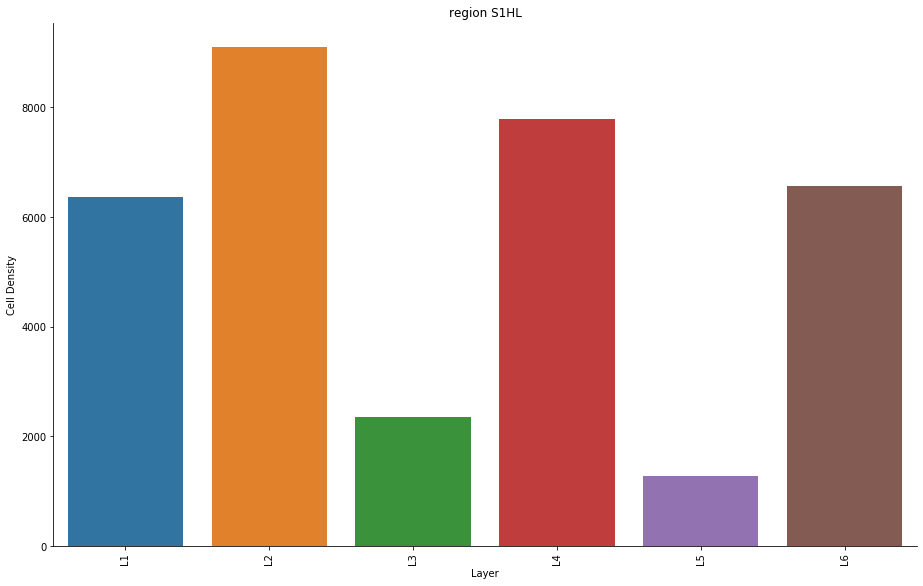

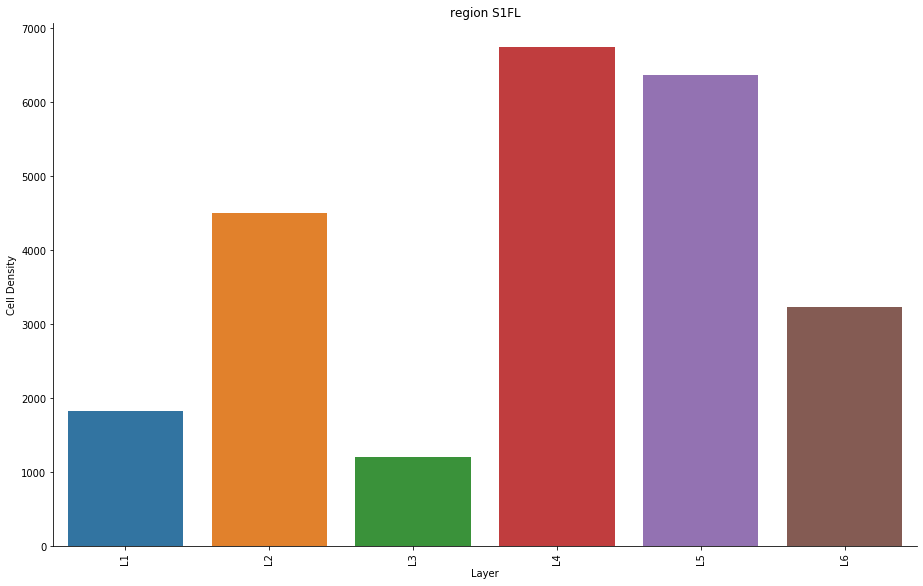

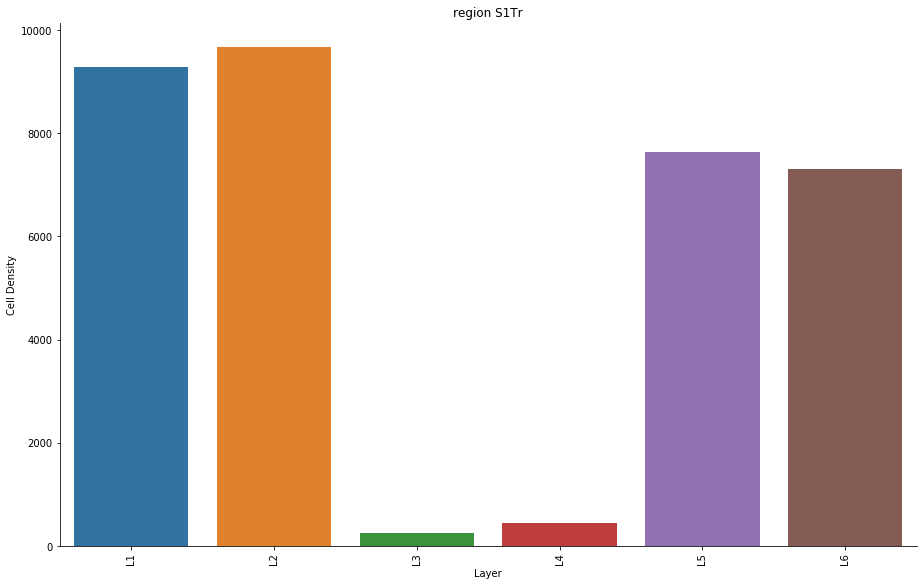

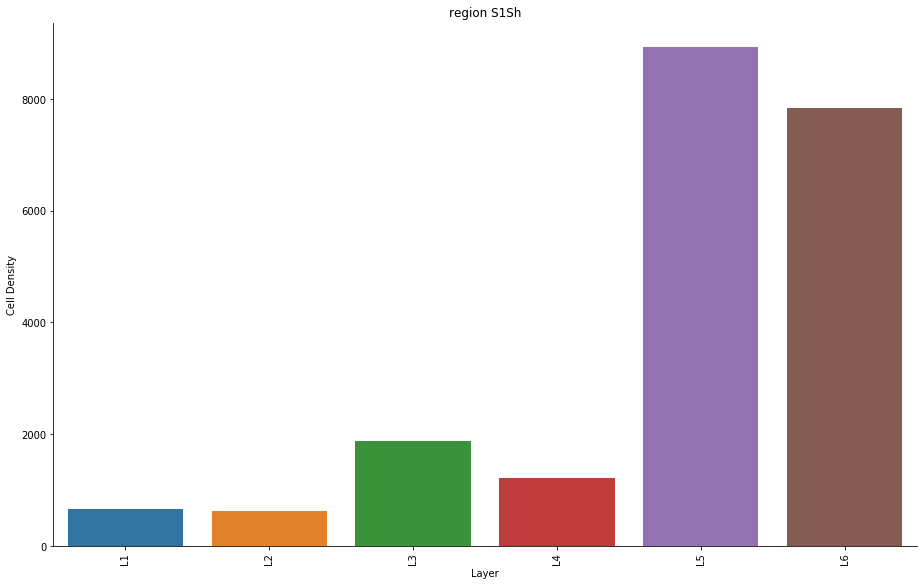

In [6]:
def get_cell_density(adapter, model, **query):
    return adapter.get_cell_density(model, **query)

results_section_cell_density =\
    Section(
        title="cell_density",
        narrative="""
        Cell densities are measured in a sample of boxes.
        """,
        data=get_cell_density,
        illustration=MultiPlot(
                mvar="region",
                plotter=Bars(
                    xvar="layer",
                    xlabel="Layer",
                    yvar="cell_density",
                    ylabel="Cell Density")))
parameters =\
    pd.DataFrame(
        [(region, layer) 
        for region in ["S1HL", "S1FL", "S1Tr", "S1Sh"]
        for layer in ["L1", "L2", "L3", "L4", "L5", "L6"]],
        columns=["region", "layer"] )
print(results_section_cell_density.data(adapter, model, parameters=parameters).head())

results_report =\
    results_section_cell_density(
        adapter, model,
        parameters=parameters)

24it [00:00, 1148.21it/s]
24it [00:00, 925.67it/s]


                         value
dataset region layer          
Model   S1HL   L1     0.224722
               L2     0.285512
               L3     0.014171
               L4     0.269013
               L5     0.150193


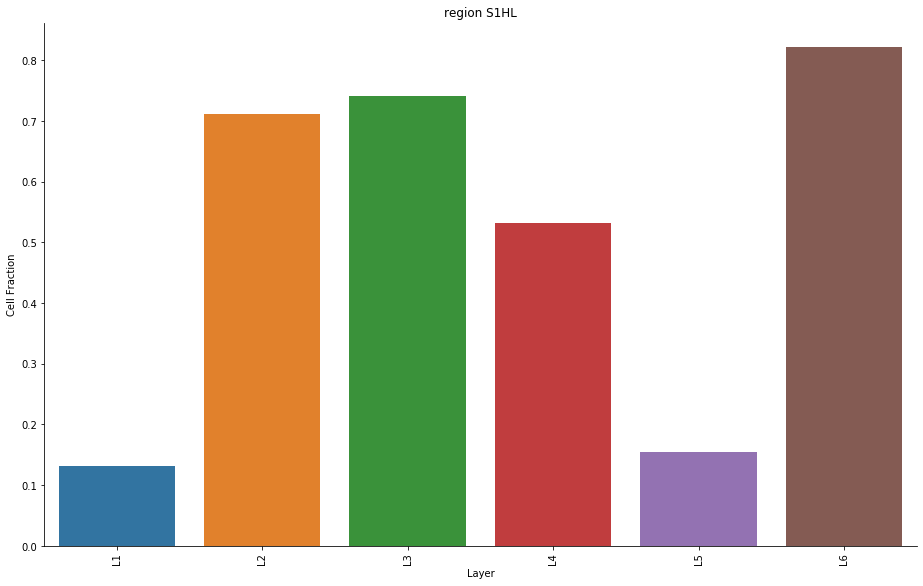

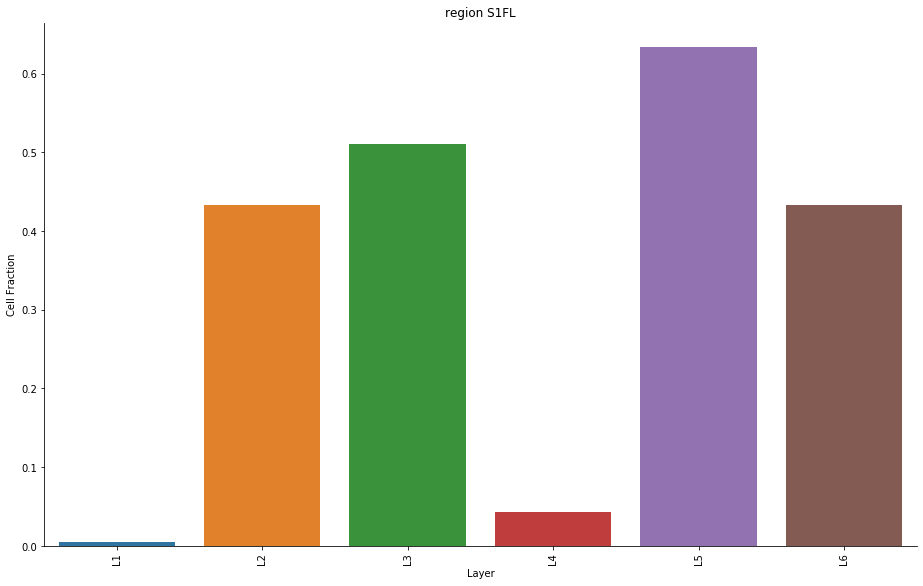

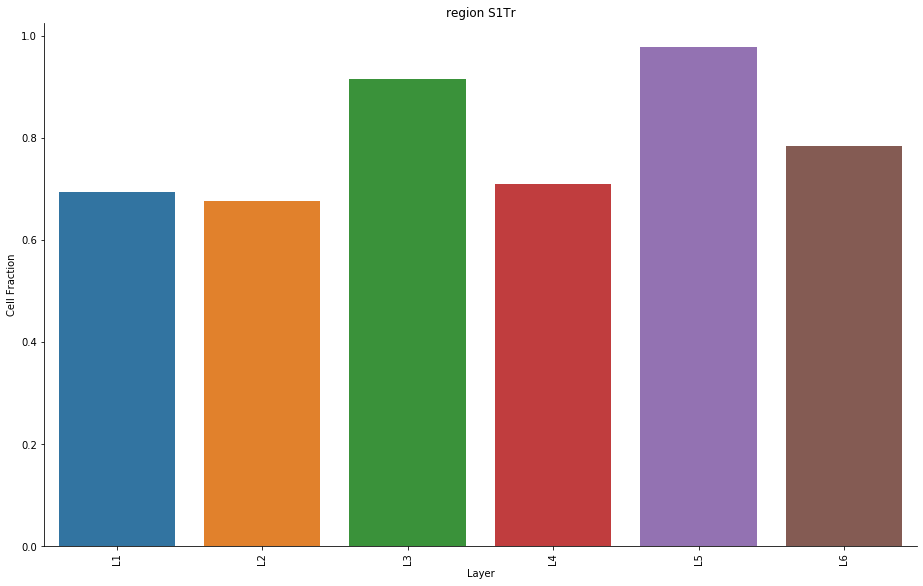

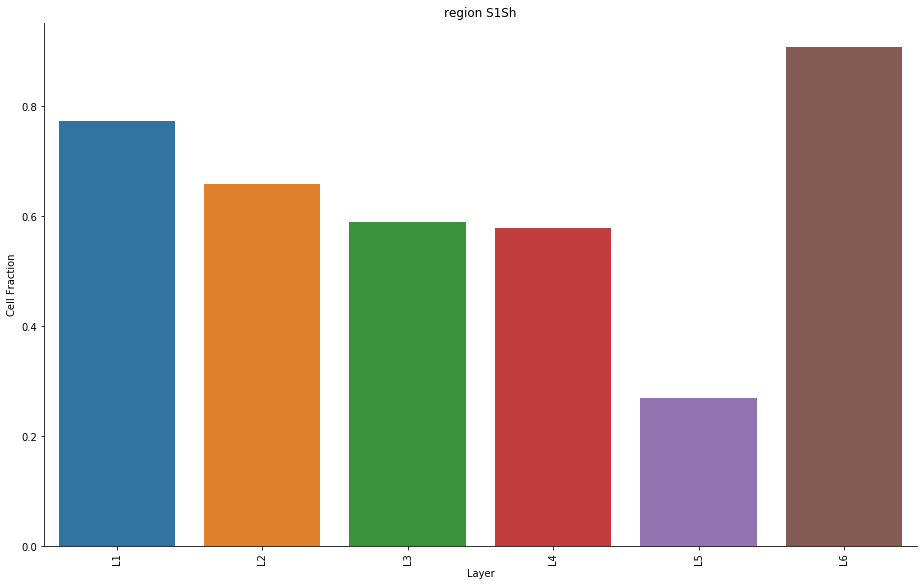

In [7]:
def get_inhibitory_cell_fraction(adapter, model, **query):
    return adapter.get_inhibitory_cell_fraction(model, **query)
    
results_section_inh_ratio =\
    Section(
        title="inhibitory_cell_fraction",
        narrative="""
        Inhibitory cell fractions were measured in a sample of boxes.
        """,
        data=get_inhibitory_cell_fraction,
        illustration=MultiPlot(
                mvar="region",
                plotter=Bars(
                    xvar="layer",
                    xlabel="Layer",
                    yvar="inhibitory_cell_fraction",
                    ylabel="Cell Fraction")))
print(results_section_inh_ratio.data(adapter, model, parameters=parameters).head())
results_report =\
    results_section_inh_ratio(
        adapter, model,
        parameters=parameters)


In [8]:
results_report.data.head()

inhibitory_cell_fraction
dataset region layer                          
Model   S1HL   L1                     0.131791
               L2                     0.711863
               L3                     0.740762
               L4                     0.532185
               L5                     0.154003

In [9]:
results_report.illustration

OrderedDict([('S1HL', <dmt.tk.plotting.figure.Figure at 0x11ae45f50>),
             ('S1FL', <dmt.tk.plotting.figure.Figure at 0x11bcf8d10>),
             ('S1Tr', <dmt.tk.plotting.figure.Figure at 0x11bcb6f90>),
             ('S1Sh', <dmt.tk.plotting.figure.Figure at 0x11bff9a50>)])

In [10]:
def append_reference_data(
        measurement,
        reference_data={},
        **kwargs):
    """
    Append reference data to measurement
    """
    measurement_dict ={
        dataset: measurement.xs(dataset, level="dataset")
        for dataset in measurement.reset_index().dataset.unique()}
    
    def _get_data(dataset):
        try:
            return dataset.data
        except AttributeError:
            return dataset
    
    measurement_dict.update({
        label: _get_data(dataset)
        for label, dataset in reference_data.items()})
    
    return measurement_dict

In [11]:
random_reference_data ={
    dataset: parameters.apply(
        lambda row: row.append(pd.Series({
            "cell_density": np.random.uniform(1., 1.e4),
            "dataset": dataset})),
        axis=1).set_index(["dataset", "region", "layer"])
    for dataset in ["DeFelipe", "Meyer", "Sonja"]}
print(random_reference_data.keys())

random_reference_data_inh_frac ={
    dataset: parameters.apply(
        lambda row: row.append(pd.Series({
            "inhibitory_cell_fraction": np.random.uniform(0., 1.),
            "dataset": dataset})),
        axis=1).set_index(["dataset", "region", "layer"])
    for dataset in ["DeFelipe", "Meyer", "Sonja"]}

dict_keys(['DeFelipe', 'Meyer', 'Sonja'])


In [12]:
section_refdata =\
    Section(
        narrative="Reference Data",
        data=random_reference_data)

refdata = section_refdata(adapter, model)
print(refdata.narrative)
print(refdata.data.keys())

Reference Data
dict_keys(['DeFelipe', 'Meyer', 'Sonja'])


In [38]:
from dmt.tk.parameters import Parameters
parsec =\
    Section(
        title="Measurement Parameters",
        narrative="""Brain regions and layers populated in brain circuit 
        model $label were used to parameterize the location in the circuit
        to measure cell densities in.
        """,
        data=lambda *a, **kw: pd.DataFrame(
            Parameters(parameters).for_sampling(*a, **kw)))
parrec =\
    parsec(adapter, model)
parrec.data.head()

,region,layer
0,S1HL,L1
1,S1HL,L1
2,S1HL,L1
3,S1HL,L1
4,S1HL,L1


In [21]:
chapter_cell_density =\
    Chapter(
        title="Cell Density",
        phenomenon=Phenomenon("Cell Density", "Number of cells in unit volume"),
        AdapterInterface=AdapterInterface,
        abstract="Abstract",
        introduction="Introduction",
        methods="Methods",
        parameters=Section(
            title="Measurement Parameters",
            narrative="Cell density is measured for each layer and region",
            data=parameters), #Parameters(parameters)),
        measurement=Section(
            title="Cell Density Measurement",
            narrative="""
            Cell densities are measured in a sample of boxes.
            """,
            data=get_cell_density),
        reference_data=Section(
            title="Reference Data",
            narrative="""
            Reference data for cell densities was obtained from experimental
            measurements.
            """,
            data=random_reference_data),
        results=Section(
            title="Results",
            narrative="""
            Comparision of cell density in $label and
            experimental reference data.
            """,
            data=append_reference_data,
            illustration=MultiPlot(
                mvar="region",
                plotter=Bars(
                    xvar="layer",
                    xlabel="Layer",
                    yvar="cell_density",
                    ylabel="Cell Density",
                    gvar="dataset"))),
        discussion="Results will be discussed after a review")

In [22]:
chapter_inhibitory_frac =\
    Chapter(
        title="Inhibitory Cell Fraction",
        phenomenon=Phenomenon(
            "Inhibitory Cell Fraction", 
            "Fraction of inhibitory cells."),
        AdapterInterface=AdapterInterface,
        abstract="Abstract",
        introduction="Introduction",
        methods="Methods",
        parameters=Section(
            title="Measurement Parameters",
            narrative="Inhibitory cell fraction is measured for each layer and region",
            data=parameters),
        measurement=Section(
            title="Inhibitory Cell ",
            narrative="""
            Inhibitory cell fractions are measured in a sample of boxes.
            """,
            data=get_inhibitory_cell_fraction),
        reference_data=Section(
            title="Reference Data",
            narrative="""
            Reference data for inhibitory cell fractions was obtained from 
            experimental measurements.
            """,
            data=random_reference_data_inh_frac),
        results=Section(
            title="Results",
            narrative="""
            Comparision of inhibitory cell fractions in $label and
            experimental reference data.
            """,
            data=append_reference_data,
            illustration=MultiPlot(
                mvar="region",
                plotter=Bars(
                    xvar="layer",
                    xlabel="Layer",
                    yvar="inhibitory_cell_fraction",
                    ylabel="Cell Fraction",
                    gvar="dataset"))),
        discussion="Results will be discussed after a review")

24it [00:00, 1079.90it/s]


                      inhibitory_cell
dataset region layer                 
Model   S1HL   L1            0.035827
               L2            0.157482
               L3            0.459929
               L4            0.182093
               L5            0.248817


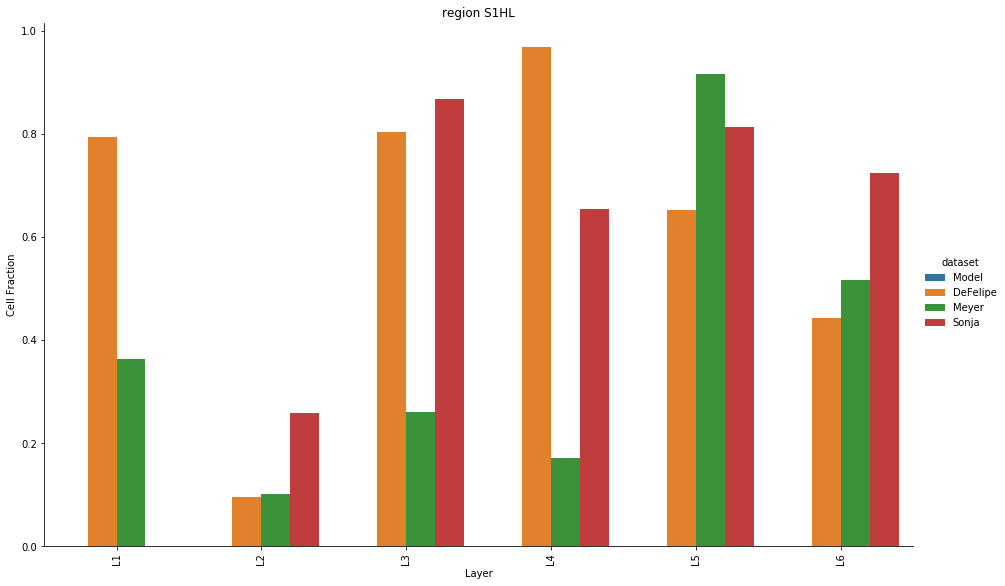

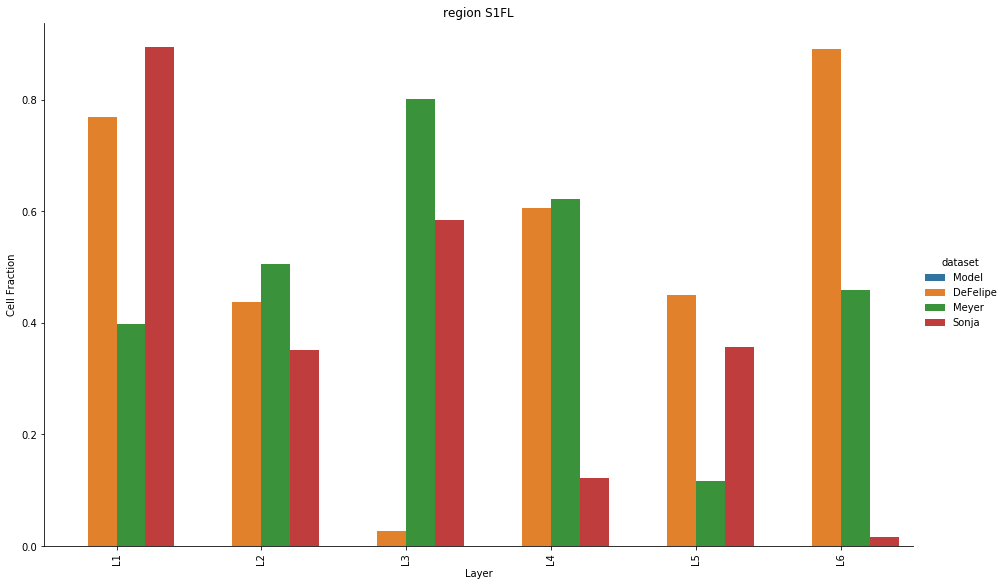

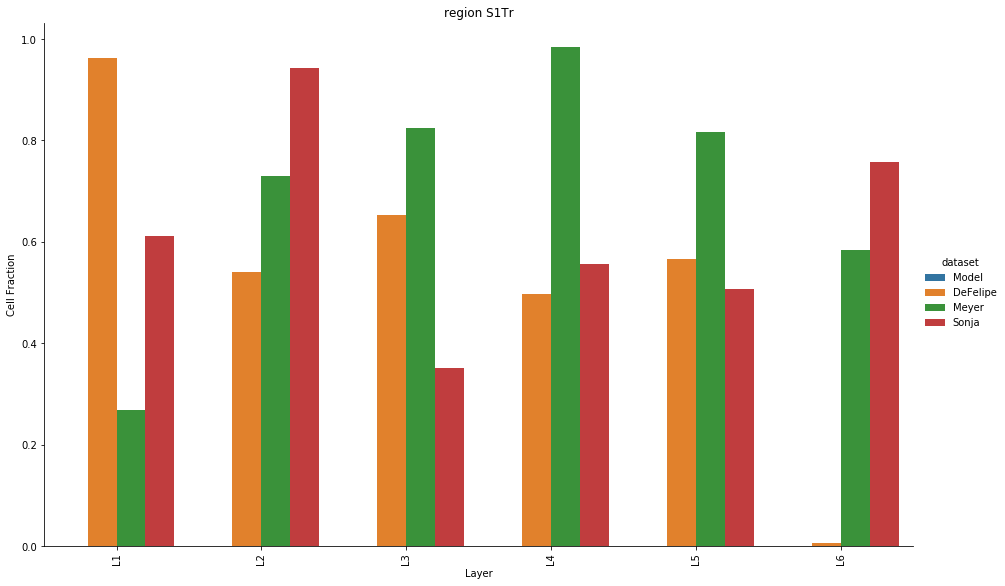

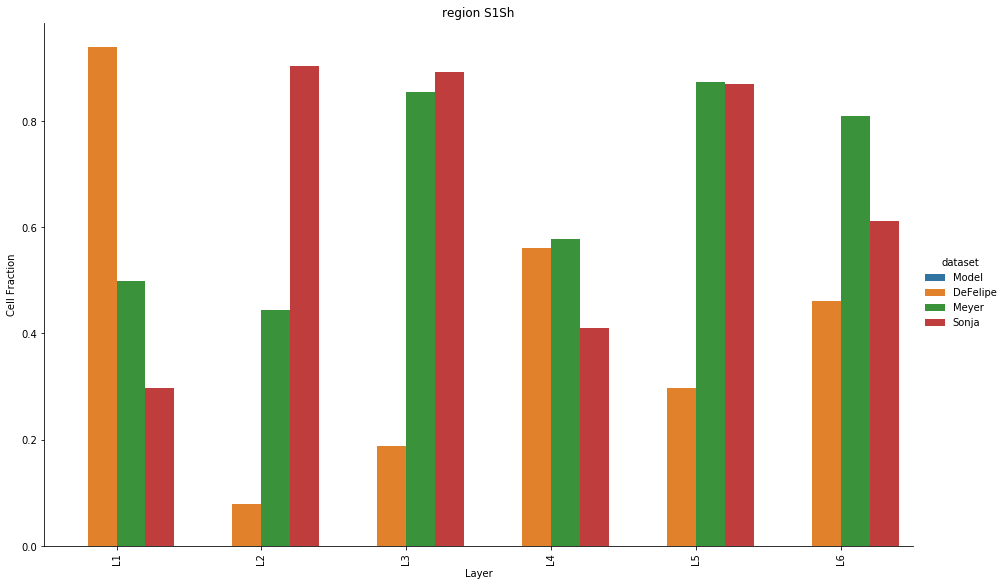

In [23]:
rd =\
    chapter_inhibitory_frac.reference_data(
        adapter, model)
m =\
    chapter_inhibitory_frac.measurement(adapter, model, parameters=parameters).data
print(m.head())
results =\
    chapter_inhibitory_frac.results(adapter, model, measurement=m, reference_data=rd.data)

In [24]:
analysis =\
    StructuredAnalysis(
        title="composition",
        author=Author.anonymous,
        phenomenon=Phenomenon(
            "Circuit composition",
            "group of phenomena relating to circuit composition"),
        AdapterInterface=AdapterInterface,
        chapters=[chapter_cell_density, chapter_inhibitory_frac],
        report=CircuitAnalysisReport)

24it [00:00, 1044.62it/s]


/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/dmt/analysis/sectioned.py Logger
INFO@<2020-03-05 10:12:39>                                                      

                Could not retrieve citations from reference data of type <class 'dmt.tk.field.record.Record43658640'>.
                



24it [00:00, 1758.37it/s]


/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/dmt/analysis/sectioned.py Logger
INFO@<2020-03-05 10:12:39>                                                      

                Could not retrieve citations from reference data of type <class 'dmt.tk.field.record.Record274385602'>.
                



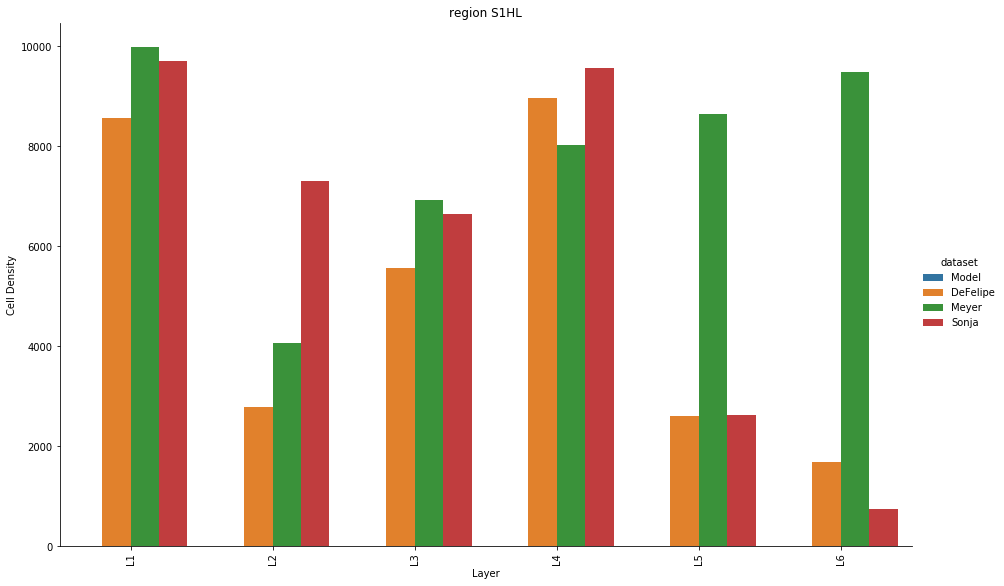

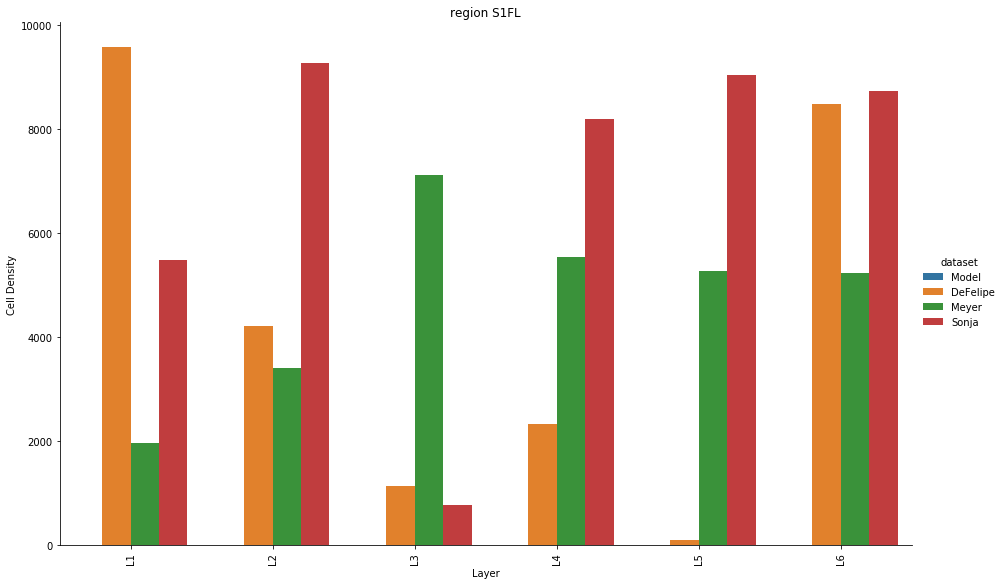

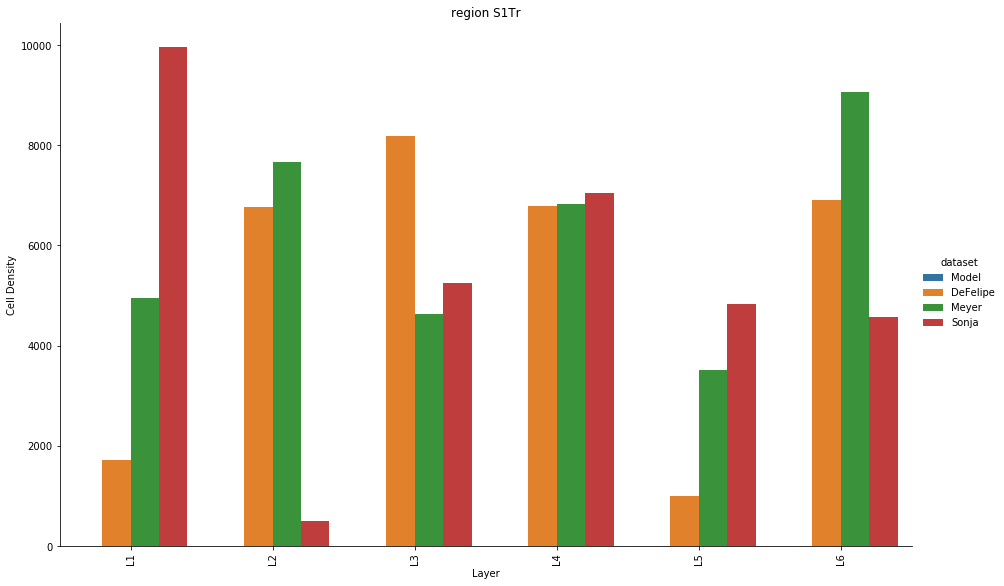

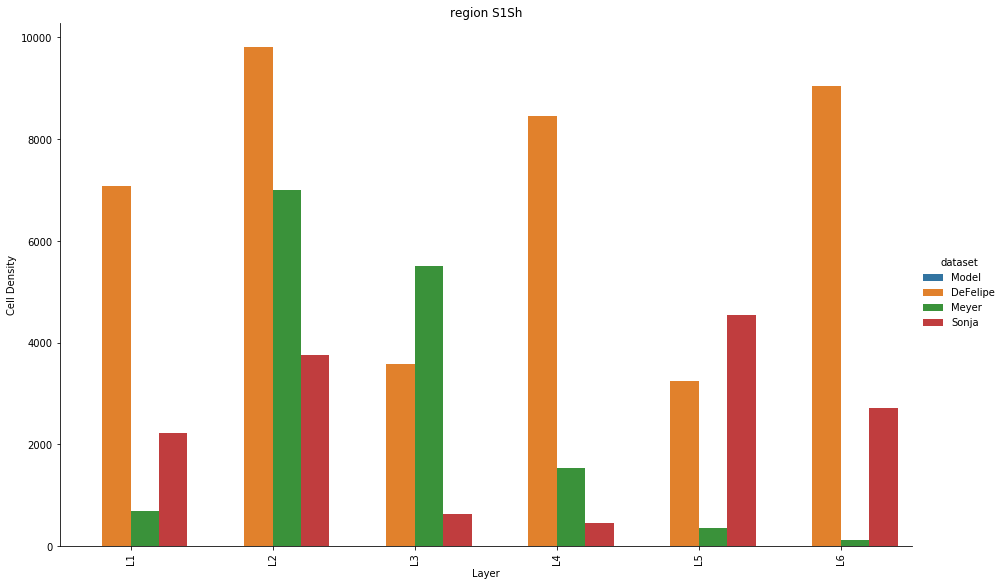

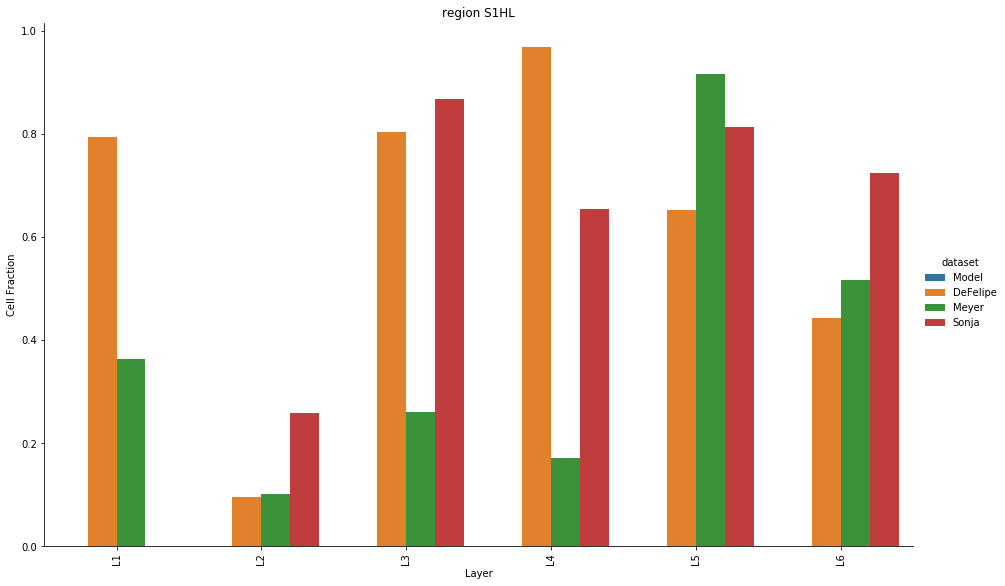

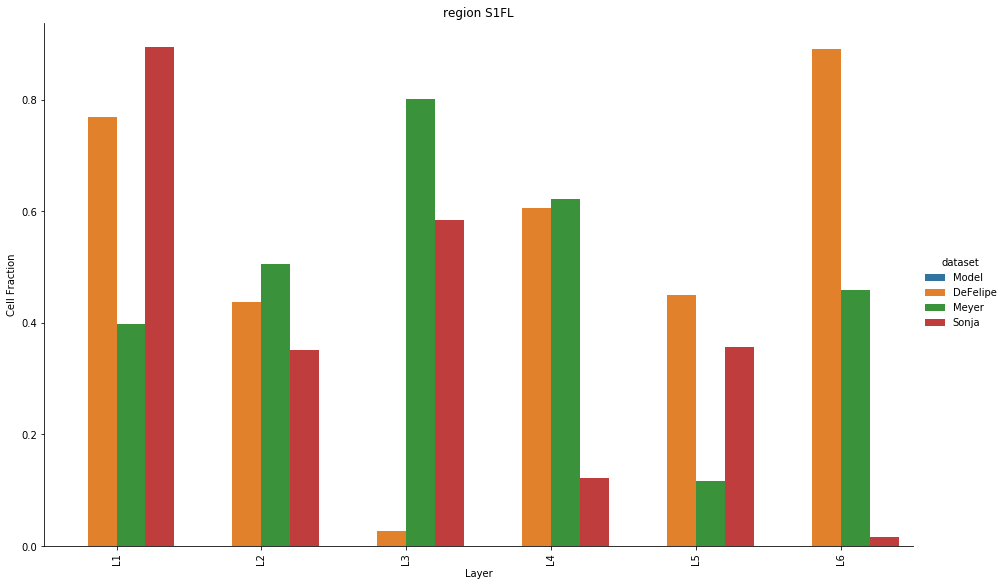

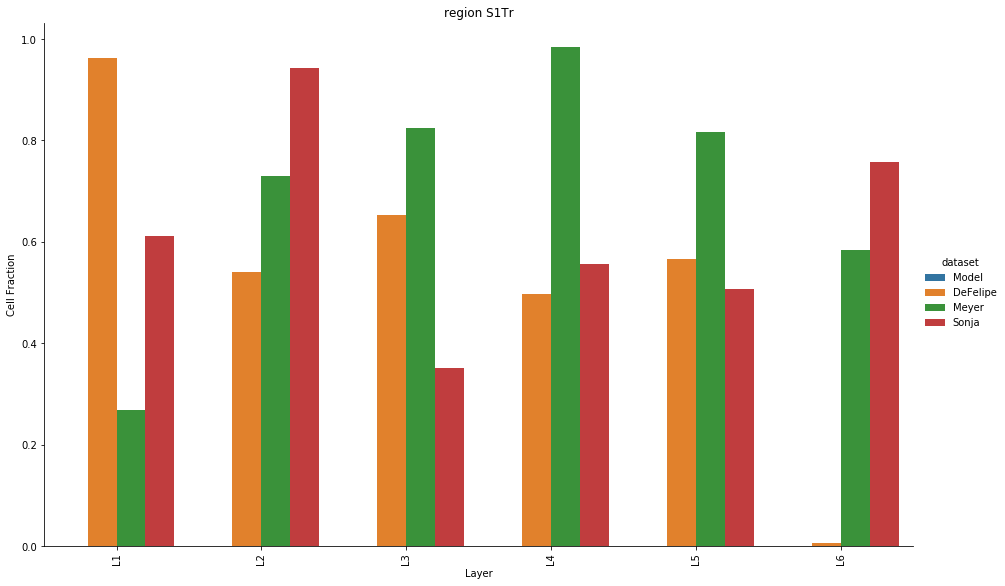

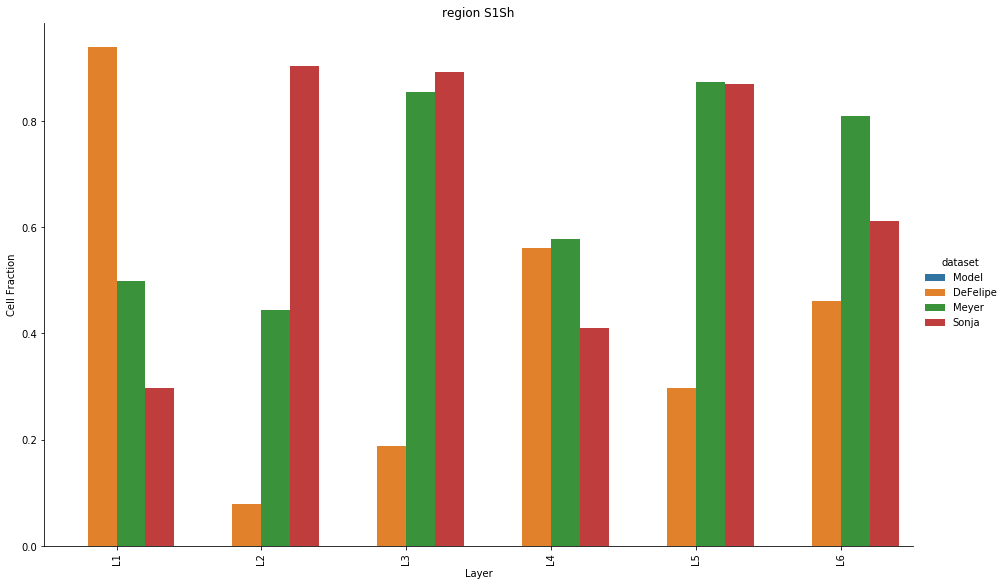

In [25]:
report = analysis(adapter, model)

In [26]:
reporter = CheetahReporter(".")
reporter.post(report)

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/analysis/reporting/__init__.py Logger
INFO@<2020-03-05 10:12:39>                                                      
Post report circuit_composition at
	 /Users/vishalsoodmuchu/work/bbp/work/validations/dmt/v2/notebooks/circuit_composition/20200305/101413

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/analysis/reporting/__init__.py Logger
INFO@<2020-03-05 10:12:39>                                                      
Post report cell_density at
	 /Users/vishalsoodmuchu/work/bbp/work/validations/dmt/v2/notebooks/circuit_composition/20200305/101413/cell_density

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/analysis/reporting/__init__.py Logger
INFO@<2020-03-05 10:12:39>                                                      
Post report inhibitory_cell_fraction at
	 /Users/vishalsoodmuchu/work/bbp/work/validations/dmt/v2/notebooks/circuit_compositio

'/Users/vishalsoodmuchu/work/bbp/work/validations/dmt/v2/notebooks/circuit_composition/20200305/101413'

In [57]:
report.label

'cell_density'

In [ ]:
cd.reference_data

In [ ]:
cd.discussion.narrative

In [ ]:
cd.discussion.narrative

In [ ]:
analysis.report(
    author=analysis.author,
    phenomenon=cd.phenomenon,
    abstract=cd.abstract,
    introduction=cd.introduction.narrative,
    methods=cd.methods.narrative,
    figures=cd.results.illustration,
    results=cd.results.narrative,
    discussion=cd.discussion.narrative,
    references=cd.references,
    provenance_model=adapter.get_provenance(model))

In [22]:
cdc = analysis.chapters[0]
cdc.introduction(adapter, model).narrative

Not Available